In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
import sklearn
import optuna
from scipy.stats import bootstrap as boot
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [62]:
df = pd.read_csv('arctic1009.csv')
df = df.rename(columns = {'date': 'month_dt'})
df

,city,population,p_avg_per_m_sec,month_dt,t,dummy_space,dummy_time,reg_russian,federal_district,lat,lon,city_id,city_rk
0,Барнаул,630877,81073.0,2022-01-01,1,0,0,Алтайский край,Сибирский,53.347361,83.77833,184,Барнаул_Алтайский край
1,Нижнеудинск,29995,52594.0,2022-01-01,1,0,0,Иркутская область,Сибирский,54.900000,99.01667,820,Нижнеудинск_Иркутская область
2,Верхняя Пышма,71335,77425.0,2022-01-01,1,0,0,Свердловская область,Уральский,56.966670,60.58333,152,Верхняя Пышма_Свердловская область
3,Бирюсинск,8632,53207.0,2022-01-01,1,0,0,Иркутская область,Сибирский,55.950000,97.81667,150,Бирюсинск_Иркутская область
4,Арамиль,19013,68613.0,2022-01-01,1,0,0,Свердловская область,Уральский,56.700000,60.83333,793,Арамиль_Свердловская область
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27542,Ипатово,26122,54183.0,2024-08-01,32,0,1,Ставропольский край,Северо-Кавказский,45.716670,42.90000,272,Ипатово_Ставропольский край
27543,Белая Холуница,9659,15444.0,2024-08-01,32,0,1,Кировская область,Приволжский,58.833330,50.85000,326,Белая Холуница_Кировская область
27544,Беломорск,7708,42477.0,2024-08-01,32,1,1,Республика Карелия,Северо-Западный,64.516670,34.76667,887,Беломорск_Республика Карелия
27545,Пудож,7356,44961.0,2024-08-01,32,0,1,Республика Карелия,Северо-Западный,61.800000,36.53333,811,Пудож_Республика Карелия


In [39]:
df = df[df['month_dt'] >= '2022-01-01']

In [64]:
x = df[df['month_dt'] >= '2022-01-01']
x = pd.pivot_table(x, index = 'city_id', aggfunc="count").reset_index()

x = x[['city_id', 'city']].rename(columns = {'city': 'count'})
x

x1 = x[x['count'] == 32]
x1


,city_id,count
0,0,32
1,1,30
2,2,32
3,3,32
4,4,21
...,...,...
919,946,32
920,947,32
921,948,32
922,949,32


,city_id,count
0,0,32
2,2,32
3,3,32
5,5,32
6,6,32
...,...,...
919,946,32
920,947,32
921,948,32
922,949,32


In [65]:
#сколько было тритмента
treat = df.loc[df['dummy_space'] == 1, 'city_id']
treat = treat.drop_duplicates()
treat =  treat.to_list()
len(treat)

#сколько осталось тритмента
city_id = x1['city_id'].to_list()
df = df[df['city_id'].isin(city_id)]
len(df.loc[df['dummy_space'] == 1, 'city_id'].unique())

30

22

In [80]:
len(df['city_id'].unique()) - 22 - 135

508

In [66]:
control_cities = list(set(list(df.query('dummy_space== 0')['city_id'])))
len(control_cities)
df['dummy_space'].sum()

643

704

In [68]:
import random
random.seed(37)
group_of_items = control_cities  
num_to_select = 135                           
list_of_random_items = random.sample(group_of_items, num_to_select)
df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))

C:\Users\lizai\AppData\Local\Temp\ipykernel_9284\3796591036.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))


In [78]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from datetime import datetime

def synth_ci(df
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , validation_start_dt = '2023-06-01'
    , y_name = 'p_avg_per_m_sec'
    , trend = False
    , dummies = True
    , optuna_penalty = 0.1
    , optuna_thresh = 0.05
    ):
    
    df['city_id'] = df['city_id'].astype(str)

    

    def sc(city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        sub_df = df[df[id_name].apply(lambda x: x in city_id_list)]
        treatment_cities = list(set(list(sub_df.query(dummy_space_name+'== 1')[id_name])))
        placebo_cities = list(set(list(sub_df.query('placebo_flg == 1')[id_name])))
        tmps =[]
        cities_list = treatment_cities+placebo_cities

        #Идём по городам воздействия и плацебо
        if len(cities_list) == 0:
            return np.nan
        for city in cities_list:
            #Берём один город плацебо|воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[dummy_space_name] == 0) & (sub_df['placebo_flg'] == 0)]
            #Вытягиваем в столбик и потом конкатенируем
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            #Добавляем фиктивную переменную города для сдвига
            tmp['tr_city_id'] = city
            tmp['tr_city'] = tmp[city]
            tmp['placebo_flg'] = 1 if city in placebo_cities else 0
            tmp.drop(columns = city, inplace = True)
            tmps += [tmp]        

        tmp = pd.concat(tmps)
        
        if trend:
            #Разница в датах считается в днях, потому что по-другому я не смог
            tmp['t'] = tmp[t_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2022-04-01', '%Y-%m-%d')
            tmp['t'] = tmp['t'].apply(lambda x: abs(x).days)

        if dummies:
            #Делаю фиктивные переменные городов воздействия/плацебо 
            enc = OneHotEncoder(sparse_output=False, drop='first')
            enc_transformed = enc.fit_transform(tmp[['tr_city_id']])
            enc_df = pd.DataFrame(columns=enc.get_feature_names_out(), data=enc_transformed)
            tmp = pd.concat([tmp.reset_index(drop=True), enc_df.reset_index(drop=True)], axis=1)      

        #Обучаем регрессию на претренде
        train = tmp.loc[tmp[t_name] < validation_start_dt]
        val = tmp.loc[(tmp[t_name] >= validation_start_dt)&(tmp[t_name] <'2023-12-01')]
        scaler = StandardScaler()
        scaler.fit(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg']))

        def objective(trial):
            lasso_alpha = trial.suggest_float('alpha', 1e-3, 1e6, log = True)
            l1_ratio = trial.suggest_float('l1_ratio', 1e-3, 1, log = True)
            regr =ElasticNet(alpha=lasso_alpha, l1_ratio=l1_ratio)
            regr.fit(scaler.transform(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])), train['tr_city'])
            val_res = pd.DataFrame({'y_true':val['tr_city']
                                   , 'y_pred': regr.predict(scaler.transform(val.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])))})
            train_res = pd.DataFrame({'y_true':train['tr_city']
                                   , 'y_pred': regr.predict(scaler.transform(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])))})
            val_r2 = r2_score(y_pred=val_res['y_pred'], y_true=val_res['y_true'])
            train_r2 = r2_score(y_pred=train_res['y_pred'], y_true=train_res['y_true'])
            return val_r2 - optuna_penalty*abs(val_r2-train_r2) if abs(val_r2-train_r2) >=optuna_thresh else val_r2

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=100)

        lr = ElasticNet(**study.best_trial.params)
        lr.fit(scaler.transform(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])), train['tr_city'])
            #Записываем в результат разницу между истинным значением и предиктом
        res = pd.DataFrame({'y_true':tmp['tr_city'], 'y_predict': lr.predict(scaler.transform(tmp.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])))
                            , t_name:tmp[t_name], 'city_id':tmp['tr_city_id'], 'placebo_flg': tmp['placebo_flg']})
        res['diff'] = res['y_true'] - res['y_predict']
        return  res
    
    cities_list = list(set(list(df[id_name])))
    #Обучаем модель на всех городах
    res1 = sc(cities_list)
    #Смотрим распределение плацебо-группы
    res2 = res1.query('placebo_flg == 1').pivot(index='month_dt', columns='city_id', values='diff').reset_index()
    #Для плацебо считаем квантили, соответствующие уровню значимости alpha
    res2['lower2.5'], res2['upper97.5'], res2['upper95'], res2['upper90'] = np.quantile(res2.drop(columns='month_dt'),0.025, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.975, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.95, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.9, axis = 1)
    res1 = res1.query('placebo_flg == 0')
    res1 = res1.groupby('month_dt', as_index=False).agg({'diff':'mean'})
    fig, ax = plt.subplots()
    # sns.lineplot(res1, x = 'month_dt', y = 'diff', hue = 'city_id', legend=False)#, ax=ax)
    plt.plot(res1['month_dt'], res1['diff'], color = 'orange')
    plt.xticks(rotation =90)
    plt.plot(res2['month_dt'], res2['lower2.5'], color = 'b')
    plt.plot(res2['month_dt'], res2['upper97.5'], color = 'b')
    plt.plot(res2['month_dt'], res2['upper95'], color = 'k' )
    plt.plot(res2['month_dt'], res2['upper90'], color = 'k')
    plt.vlines(x = ['2023-12-01', validation_start_dt], ymin = res2['lower2.5'].min(), ymax = res2['upper97.5'].max(), colors='k', linestyles='--')

    return res1

In [73]:
df.isna().sum()

city                0
population          0
p_avg_per_m_sec     0
month_dt            0
t                   0
dummy_space         0
dummy_time          0
reg_russian         0
federal_district    0
lat                 0
lon                 0
city_id             0
city_rk             0
placebo_flg         0
dtype: int64

C:\Users\lizai\AppData\Local\Temp\ipykernel_9284\4186117062.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)
[I 2024-09-16 22:37:19,043] A new study created in memory with name: no-name-a6d065a0-0282-43a5-87e6-52784be39651
c:\Users\lizai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.513e+10, tolerance: 1.854e+08
  model = cd_fast.enet_coordinate_descent(
[I 2024-09-16 22:37:21,122] Trial 0 finished with value: 0.9046798157008634 and parameters: {'alpha': 0.0

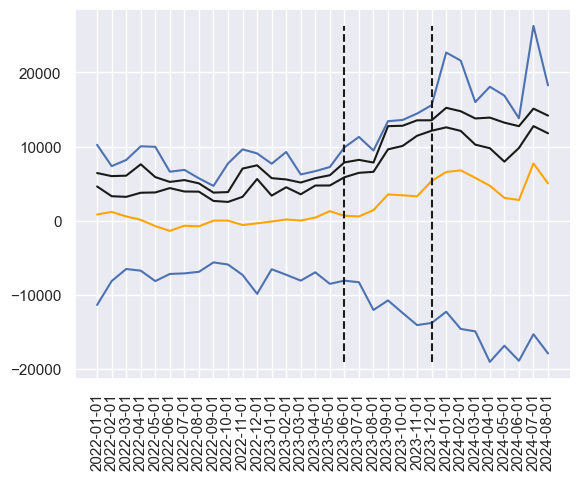

In [79]:
data = synth_ci(df, validation_start_dt='2023-06-01', optuna_penalty=1, optuna_thresh=0.01)

C:\Users\lizai\AppData\Local\Temp\ipykernel_9284\4186117062.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_id'] = df['city_id'].astype(str)
[I 2024-09-16 22:42:38,136] A new study created in memory with name: no-name-ea13184e-de9e-41a5-85dc-a91412609634
[I 2024-09-16 22:42:38,226] Trial 0 finished with value: -0.14946884881823186 and parameters: {'alpha': 779923.6587965436, 'l1_ratio': 0.11478779342128652}. Best is trial 0 with value: -0.14946884881823186.
[I 2024-09-16 22:42:38,374] Trial 1 finished with value: -0.11161786150233066 and parameters: {'alpha': 1622.5847063071235, 'l1_ratio': 0.05317450946596523}. Best is trial 1 with value: -0.11161786150233066.
[I 2024-09-16 22:42:38,477] Trial 2 finished with value: -0.138514716372

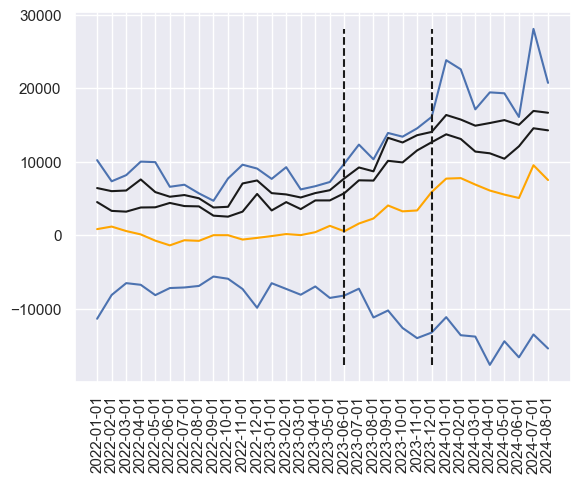

In [81]:
data = synth_ci(df, validation_start_dt='2023-06-01', optuna_penalty=1, optuna_thresh=0.01)

In [50]:
data = synth_ci(df, lasso_alpha= 10, validation_start_dt='2023-06-01')#.pivot(index='month_dt', columns='city_id', values='diff').reset_index()

TypeError: synth_ci() got an unexpected keyword argument 'lasso_alpha'

In [83]:
sns.lineplot(data, x = 'month_dt', y = 'diff', hue = 'city_id', legend=False)

ValueError: Could not interpret value `city_id` for `hue`. An entry with this name does not appear in `data`.

<Axes: xlabel='month_dt', ylabel='diff'>

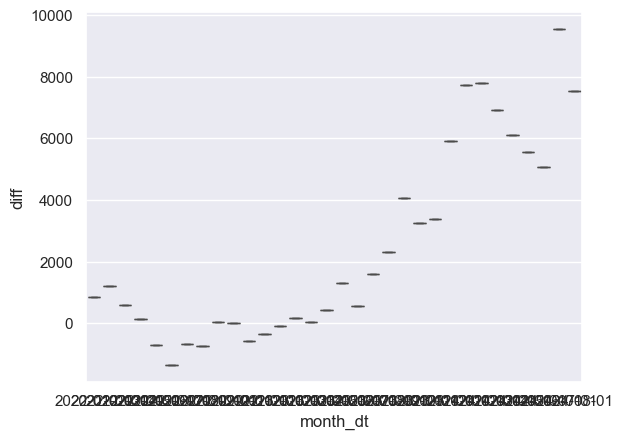

In [82]:
sns.boxplot(data, x = 'month_dt', y = 'diff', legend=False)

In [56]:
t_treatment= '2023-06-01'
data2 = synth_ci(df, alpha = 200, t_treatment= t_treatment).pivot(index='month_dt', columns='city_id', values='diff').reset_index()
data2

TypeError: synth_ci() got an unexpected keyword argument 'alpha'

In [57]:
alpha = 0.05
data2['lower'], data2['upper'] = np.quantile(data2.drop(columns='month_dt'),alpha/2, axis = 1), np.quantile(data2.drop(columns='month_dt'),1-alpha/2, axis = 1)
data2

NameError: name 'data2' is not defined

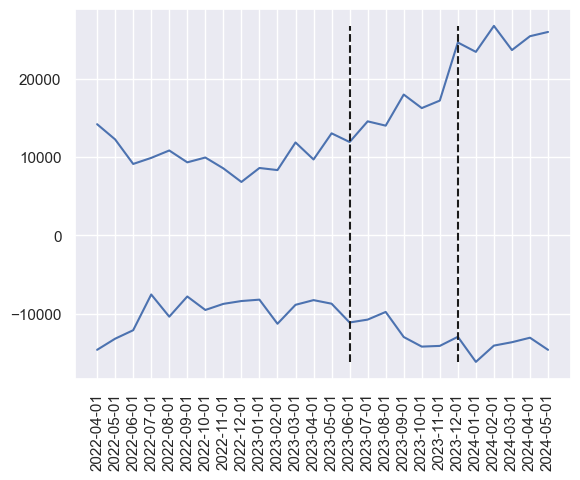

In [31]:
plt.plot(data2['month_dt'], data2['upper'], color = 'b')
plt.xticks(rotation =90)
plt.plot(data2['month_dt'], data2['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data2['lower'].min(), ymax = data2['upper'].max(), colors='k', linestyles='--')